<a href="https://colab.research.google.com/github/meedastitou/CNN_MNIST/blob/main/cnn_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install idx2numpy

In [67]:
import torch
import idx2numpy
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt


In [4]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
train_images_path = "/content/data/MNIST/train-images.idx3-ubyte"
train_labels_path = "/content/data/MNIST/train-labels.idx1-ubyte"
test_images_path = "/content/data/MNIST/t10k-images.idx3-ubyte"
test_labels_path = "/content/data/MNIST/t10k-labels.idx1-ubyte"

In [12]:
# Load data into NumPy arrays
train_images = idx2numpy.convert_from_file(train_images_path)
train_labels = idx2numpy.convert_from_file(train_labels_path)
test_images = idx2numpy.convert_from_file(test_images_path)
test_labels = idx2numpy.convert_from_file(test_labels_path)

In [13]:
# Verify dimensions
print(f"Train Images: {train_images.shape}, Train Labels: {train_labels.shape}")
print(f"Test Images: {test_images.shape}, Test Labels: {test_labels.shape}")

Train Images: (60000, 28, 28), Train Labels: (60000,)
Test Images: (10000, 28, 28), Test Labels: (10000,)


In [14]:
# customize my data for pytorch
class mnist_data(Dataset):
  def __init__(self, images, labels, transform):
    self.images = images
    self.labels = labels
    self.transform = transform
    self.checking_demention = self.transform(images) # just for checking dementiion and transformation to ternosr
  def __len__ (self):
    return len(self.labels)
  def __getitem__(self, index) :
    image = self.images[index]
    label = self.labels[index]
    image = self.transform(image)
    return image, label


In [15]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

In [16]:
train_dataset = mnist_data(train_images, train_labels, transform)
test_dataset = mnist_data(test_images, test_labels, transform)


# create dataloader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [17]:
print(f"Train Images: {train_dataset.checking_demention.shape}")

Train Images: torch.Size([28, 60000, 28])


In [54]:
# definition of model cnn
class cnn(nn.Module):
  def __init__(self):
    super(cnn, self).__init__()
    # convolution layer and pooling
    self.conv1 = nn.Conv2d(1, 4, 5, stride=1, padding=0)
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(4, 8, 5, stride=1, padding=0)
    self.relu = nn.ReLU()

    # linear layer
    self.l1 = nn.Linear(8*4*4 , 40)
    self.l2 = nn.Linear(40, 20)
    self.outut = nn.Linear(20, 10)

  def forward(self, x):
    x = self.pool1(self.relu(self.conv1(x)))
    x = self.pool1(self.relu(self.conv2(x)))

    x = x.view(-1, 8 * 4 * 4)  # Flatten the tensor
    x = self.relu(self.l1(x))

    x = self.relu(self.l2(x))
    x = self.outut(x)
    return x

model = cnn().to(device)

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization


In [61]:
def train_phase(model, data, loss, optimizer, epochs=10):
  model.train()
  for epoch in range(epochs):
    total_loss = 0.0
    for images, labels in tqdm(data, desc=f"the {epoch+1}/{epochs}"):
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      err = loss(outputs, labels)

      optimizer.zero_grad()
      err.backward()
      optimizer.step()

      total_loss += err.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")
      #print(images.shape)
      #print("=======")



In [62]:
train_phase(model, train_loader, criterion, optimizer)

the 0/10: 100%|██████████| 938/938 [00:20<00:00, 46.23it/s]


Epoch [1/10], Loss: 0.0380


the 1/10: 100%|██████████| 938/938 [00:20<00:00, 45.00it/s]


Epoch [2/10], Loss: 0.0366


the 2/10: 100%|██████████| 938/938 [00:20<00:00, 45.68it/s]


Epoch [3/10], Loss: 0.0335


the 3/10: 100%|██████████| 938/938 [00:20<00:00, 45.96it/s]


Epoch [4/10], Loss: 0.0331


the 4/10: 100%|██████████| 938/938 [00:19<00:00, 47.03it/s]


Epoch [5/10], Loss: 0.0308


the 5/10: 100%|██████████| 938/938 [00:20<00:00, 46.55it/s]


Epoch [6/10], Loss: 0.0283


the 6/10: 100%|██████████| 938/938 [00:20<00:00, 46.82it/s]


Epoch [7/10], Loss: 0.0288


the 7/10: 100%|██████████| 938/938 [00:20<00:00, 45.87it/s]


Epoch [8/10], Loss: 0.0254


the 8/10: 100%|██████████| 938/938 [00:19<00:00, 48.98it/s]


Epoch [9/10], Loss: 0.0257


the 9/10: 100%|██████████| 938/938 [00:20<00:00, 46.32it/s]

Epoch [10/10], Loss: 0.0245


In [72]:
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    return accuracy, f1


In [73]:
accuracy, f1 = evaluate_model(model, test_loader)

100%|██████████| 157/157 [00:04<00:00, 38.20it/s]


Accuracy: 0.9857, F1 Score: 0.9857


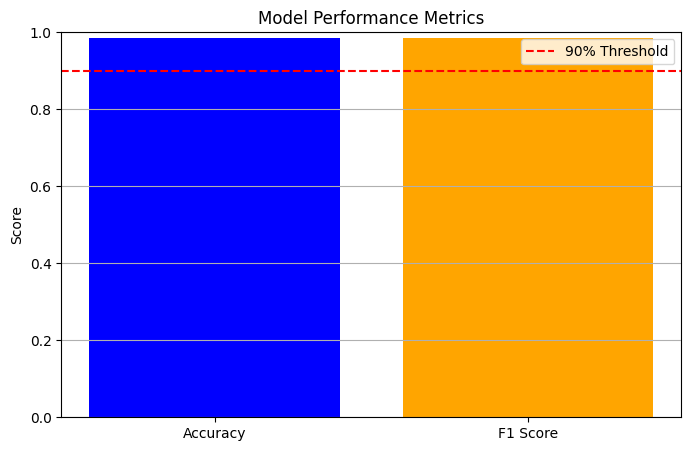

In [76]:
# Data for plotting
metrics = ['Accuracy', 'F1 Score']
values = [accuracy, f1]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'orange'])
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.axhline(y=0.90, color='red', linestyle='--', label='90% Threshold')  # Optional threshold line
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.show()